# Quick start guide


## Installation
### Stable
Fri can be installed via the Python Package Index (PyPI).

If you have `pip` installed just execute the command

    pip install fri
   
to get the newest stable version.

The dependencies should be installed and checked automatically.
If you have problems installing please open issue at our [tracker](https://github.com/lpfann/fri/issues/new).

### Development
To install a bleeding edge dev version of `FRI` you can clone the GitHub repository using

    git clone git@github.com:lpfann/fri.git

and then check out the `dev` branch: `git checkout dev`.

To check if everything works as intented you can use `pytest` to run the unit tests.
Just run the command

    pytest

in the main project folder

## Using FRI
Now we showcase the workflow of using FRI on a simple classification problem.

### Data
To have something to work with, we need some data first.
`fri` includes a generation method for binary classification and regression data.

In our case we need some classification data.

In [51]:
from fri import genClassificationData

We want to create a small set with a few features.

Because we want to showcase the all-relevant feature selection, we generate multiple strongly and weakly relevant features.

In [52]:
n = 100
features = 6
strongly_relevant = 2
weakly_relevant = 2

In [53]:
X,y = genClassificationData(n_samples=n,
                            n_features=features,
                            n_strel=strongly_relevant,
                            n_redundant=weakly_relevant,
                            random_state=123)

Generating dataset with d=6,n=100,strongly=2,weakly=2, partition of weakly=None


The method also prints out the parameters again.

In [54]:
X.shape

(100, 6)

We created a binary classification set with 6 features of which 2 are strongly relevant and 2 weakly relevant.

#### Preprocess
Because our method expects mean centered data we need to standardize it first.
This centers the values around 0 and deviation to the standard deviation

In [55]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

### Model
Now we need to creata a Model. 
We use the `FRIClassification` class.

For regression one would use `FRIRegression`

In [56]:
from fri import FRIClassification
fri_model = FRIClassification()

In [57]:
fri_model

FRIClassification(C=None, debug=False, n_resampling=3,
         optimum_deviation=0.001, parallel=False, random_state=None)

We used no parameters for creation so the defaults are active.

`C=None` means, that `FRI` itself chooses the regularization parameter `C` using crossvalidation on a fixed grid.

By default, parallel computation is also disabled but can be enabled using `parallel=True`.

#### Fitting to data
Now we can just fit the model to the data using `scikit-learn` like commands.

In [58]:
fri_model.fit(X_scaled,y)

The resulting feature relevance bounds are saved in the `interval_` variable.

In [59]:
fri_model.interval_

array([[0.45993233, 0.46169499],
       [0.26954548, 0.27159876],
       [0.        , 0.25802293],
       [0.        , 0.25802293],
       [0.00516909, 0.00711219],
       [0.00446591, 0.00694219]])

In [60]:
fri_model.interval_.shape

(6, 2)

The bounds are grouped in 2d sublists for each feature.


To acess the relevance bounds for feature 2 we would use

In [62]:
fri_model.interval_[2]

array([0.        , 0.25802293])

The relevance classes are saved in the corresponding variable `relevance_classes_`:

In [63]:
fri_model.relevance_classes_

array([2, 2, 1, 1, 0, 0])

`2` denotes strongly relevant features, `1` weakly relevant and `0` irrelevant.

#### Plot results

The bounds in numerical form are useful for postprocesing.
If we want a human to look at it, we recommend the plot function `plot_relevance_bars`.

We can also color the bars according to `relevance_classes_`

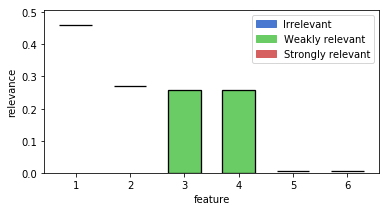

In [66]:
# Import plot function
from fri.plot import plot_relevance_bars
import matplotlib.pyplot as plt
%matplotlib inline
# Create new figure, where we can put an axis on
fig, ax = plt.subplots(1, 1,figsize=(6,3))
# plot the bars on the axis, colored according to fri
out = plot_relevance_bars(ax,fri_model.interval_,classes=fri_model.relevance_classes_)

In the plot we can see both strongly relevant features 1 and 2 not allowing much change in their contribution.
Feature 3 and 4 are highly correlated and show therefore a big variance.
Noise features 5 and 6 show some necessary contribution which can be accounted to numerical instabilities of the solver.

### Print internal Parameters

If we want to take at internal parameters, we can use the `debug` flag in the model creation.

In [67]:
fri_model = FRIClassification(debug=True)

In [68]:
fri_model.fit(X_scaled,y)

loss 0.517120931358002
L1 6.743126681372926
offset 0.32474176019022094
C 1
score 1.0
coef:
[[ 3.10516847]
 [-1.82001413]
 [ 0.86614471]
 [-0.86614471]
 [-0.03919911]
 [-0.03971916]]


This prints out the parameters of the baseline model `loss` (sum of slack), `L1` ($L_1$ norm of weight vector) and `offset` (from the origin).
`coef` shows the coefficients of the baseline model.

One can also see the best `C` according to gridsearch and the training score of the model in `score`.

These values can also be accessed by the object variables.

##### Print out hyperparameter found by GridSearchCV:

In [69]:
fri_model.tuned_C_

1

or the baseline parameters:

In [70]:
fri_model.optim_L1_

6.743126681372926

### Setting constraints manually
Our model also allows to compute relevance bounds when the user sets a given range for the features.

#### Presets
Presets are encoded using a array in the same shape as the `interval_` variable.
Each value represents the user given minimum and maximum contribution of the feature.
If one would set both values to be the same, we interpret this feature as fixed.

Additionally, entries with `np.nan` are interpreted as not-set or free.

In [22]:
import numpy as np
preset = np.full_like(fri_model.interval_,np.nan,dtype=np.double)

Now we have a preset array without any constraints:

In [23]:
preset

array([[nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan]])

#### Example
As an example, let us constrain feature 3 from our example to the minimum relevance bound.

Note the different indexing using numpy (3 -> 2)

In [24]:
preset[2] = fri_model.interval_[2, 0]

We use the function `constrained_intervals_`.

Note: we need to fit the model before we can use this function.
We already did that, so we are fine.

In [31]:
constrained_interval = fri_model.constrained_intervals_(preset=preset)

In [32]:
constrained_interval

array([[0.45993233, 0.46169499],
       [0.26954548, 0.27159876],
       [0.        , 0.        ],
       [0.25608488, 0.25802293],
       [0.00516909, 0.00711219],
       [0.00446591, 0.0069422 ]])

Feature 3 is set to its minimum (at 0).

How does it look visually?

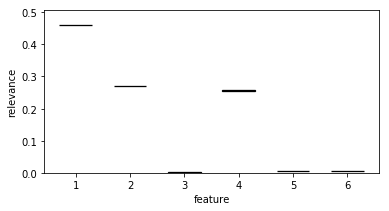

In [33]:
fig, ax = plt.subplots(1, 1,figsize=(6,3))
out = plot_relevance_bars(ax, constrained_interval)

Feature 3 is reduced to its minimum (no contribution).

In turn, its correlated partner feature 4 had to take its maximum contribution.